# Analiza danych z pliku tekstowego Cell_Phones_&_Accessories.txt
***
# 1 Cel zadania
Celem w zadaniu jest analiza danych z pliku tekstowego Cell_Phones_&_Accessories.txt oraz uzyskanie z niego jak największej ilości informacji.
# 2 Propozycje informacji które można uzyskać z tekstu
- Ilu gwiazdkom odpowiada dana recenzja? Na podstawie tekstu recenzji zostanie wygenerowana jej ocena w skali(1-5).(w notatniku 1)
- Generator krótkiego podsumowania na podstawie tekstu recenzji. (w tym notatniku)
- Analiza statystyczna danych. Bez Machine Learningu. (w notatniku 3)

# Uwaga
Komentarze we fragmentach kodu pisane są w języku angielskim

## Drugim zadaniem będzie stworzenie sieci neuronowej która na podstawie tekstu recenzji generować będzie jej krótki opis

### Tutaj dołączmy potrzebne biblioteki i zdefiniujmy wykorzystywane później stałe

In [1]:
# Some imports
from __future__ import annotations
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from common.data_loader import DataGeneratorTitles
from common.preprocess import preprocess_titles
import numpy as np
import matplotlib.pyplot as plt
import shutil
import numpy as np
import os
import random
import pickle


# If they dont exist create them
try:
    os.mkdir('models') 
except:
    pass
try:
    os.mkdir('img')
except:
    pass
try:
    os.mkdir('results')
except:
    pass


# Just the name of our input file. Now we dont need to remember it 
phones_file_name: str
phones_file_name = "source/Cell_Phones_&_Accessories.txt"

# Vocabulary size
max_words = 20000
# Review size
max_len_review = 500
# Title size
max_len_title = 10
# Batch size
batch_size = 64

W komórce poniżej przetworzymy dane i zapiszemy je jako tablice numpy. Można pominąć, jeżeli wykonało się tę akcję wcześniej

In [2]:
preprocess_titles(phones_file_name)

Stworzenie funkcji która zapewni dane treningowe. W sieci neuronowej mamy 2 wejścia:
1 Wejście tekstu recenzji <br>
2 Wejście aktualnego stanu tytułu

Tytuł recenzji we wczytanym przez nas pliku tekstowym ma $N$ słów i ma on postać:
$[słowo1, słowo2,...,słowoN]$.

Możemy zatem wyodrębnić z niego następujące sekwencje:

$[]$

$[słowo1]$

$[słowo1, słowo2]$

        .
        
        .
        
        .
        
$[słowo1, słowo2,...,słowoN]$

Dla każdej recenzji będziemy mieli zatem $N+1$ możliwych kombinacji sekwencji danych w tytule.


Inicjacja generatorów

In [3]:
# Initialize data generators
train_gen = DataGeneratorTitles(0, 266336, batch_size=batch_size,
                                max_words=max_words, max_review_size=max_len_review,
                                max_title_size=max_len_title)

test_gen = DataGeneratorTitles(266336, 299628, batch_size=batch_size,
                               max_words=max_words, max_review_size=max_len_review,
                               max_title_size=max_len_title)

val_gen = DataGeneratorTitles(299628, 332920, batch_size=batch_size,
                              max_words=max_words, max_review_size=max_len_review,
                              max_title_size=max_len_title)

Stwórzmy funkcję generującą następne słowo na podstawie rozkładu prawdopodobieństwa wystąpienia go. Większy epsilon to większa losowość działań. Dla 1.0 korzystamy z rozkładu podanego na wejściu

In [4]:
def get_word(predictions:np.array, epsilon:float=0.5):
    predictions = predictions.astype('float64')
    predictions = np.log(predictions) / epsilon
    predictions = np.exp(predictions)
    predictions = predictions/np.sum(predictions)
    pred: np.array = np.random.multinomial(1, predictions[0])
    return np.argmax(pred)

Próbujemy przewidzieć następne słowa na podstawie dwóch wejść.

1 Tekst recenzji <br>
2 Słowa które znalazły się już w tytule recenzji i czekają na kompana


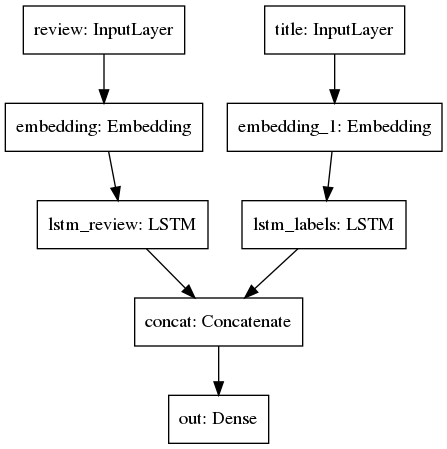

In [5]:
# Let's create model
input_review = Input(shape=(None,), name='review')
input_labels = Input(shape=(None,), name='title')

embedded_review = Embedding(max_words, 128, input_length=max_len_review)(input_review)
embedded_labels = Embedding(max_words, 128, input_length=max_len_title)(input_labels)

lstm_review = LSTM(64, name='lstm_review', dropout=0.2)(embedded_review)
lstm_labels = LSTM(32, name='lstm_labels', dropout=0.2)(embedded_labels)

concat = concatenate([lstm_review, lstm_labels], axis=-1, name='concat')
ans = Dense(max_words, activation='softmax', name='out')(concat)

model_generator = Model([input_review, input_labels], ans)

model_generator.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics='accuracy')

plot_model(model_generator, to_file='img/model_generator.png')


In [6]:
# Let's train our model
try:
    shutil.rmtree('results/generator')
except:
    pass

os.mkdir('results/generator')

callbacks = [TensorBoard(log_dir='results/generator', histogram_freq=1, embeddings_freq=1)]

history_generator = model_generator.fit(train_gen,
                                        validation_data=val_gen,
                                        epochs=13,
                                        batch_size=batch_size,
                                        use_multiprocessing=True,
                                        workers=8,
                                        callbacks = callbacks)

model_generator.save_weights("models/generator.h5")

Epoch 1/13
   1/4161 [..............................] - ETA: 1s - loss: 9.9041 - accuracy: 0.0000e+00WARNING:tensorflow:From /home/patryk/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4161/4161 [==============================] - 222s 53ms/step - loss: 6.0330 - accuracy: 0.0910 - val_loss: 5.7488 - val_accuracy: 0.1439
Epoch 2/13
4161/4161 [==============================] - 207s 50ms/step - loss: 5.5014 - accuracy: 0.1695 - val_loss: 5.5037 - val_accuracy: 0.1797
Epoch 3/13
4161/4161 [==============================] - 207s 50ms/step - loss: 5.3859 - accuracy: 0.1938 - val_loss: 5.5044 - val_accuracy: 0.1947
Epoch 4/13
4161/4161 [==============================] - 207s 50ms/step - loss: 5.4400 - accuracy: 0.2053 - val_loss: 5.6880 - val_accuracy: 0.2026
Epoch 5/13
4161/4161 [==========

520/520 [==============================] - 17s 33ms/step - loss: 5.9948 - accuracy: 0.2093
[5.994781017303467, 0.20928485691547394]


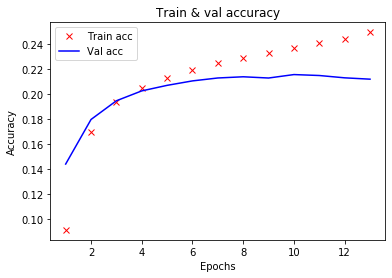

In [7]:
print(model_generator.evaluate(test_gen))

acc = history_generator.history['accuracy']
val_acc = history_generator.history['val_accuracy']


plt.plot(range(1, len(acc)+1), acc, 'rx', label='Train acc')
plt.plot(range(1, len(acc)+1), val_acc, 'b', label='Val acc')
plt.title('Train & val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()                 


Jak widać można by nawet poeksperymentować ze zwiększeniem modelu. A teraz wisienka na torcie, czyli sprawdzenie **jak to działa**:

In [8]:
model_generator.load_weights("models/generator.h5")
my_review:list = ["This cable saves me a lot of money. I don't need to buy stuff online when now I can download it straight to my PC. makes it easy to transfer Pictures, ring tones, contact numbers. It is great to put things on and off. Also great for keeping a back up."]
my_summary:list = [[]]

with open('source/stars/tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

my_dict: dict = tokenizer.word_index
reverse_my_dict:dict = dict([(value, key) for (key, value) in my_dict.items()])
# Just some preparations
my_review = tokenizer.texts_to_sequences(my_review)
my_review_np: np.array = pad_sequences(my_review, maxlen = max_len_review)

my_summary = tokenizer.texts_to_sequences(my_summary)
my_summary_np: np.array = pad_sequences(my_summary, maxlen = max_len_title)

for i in range(5):
    probs = model_generator.predict({"review": my_review_np, "title": my_summary_np})
    word = get_word(probs, 0.8)
    my_summary.append(my_summary[-1]+[word])

print("Title:")
for i, word in enumerate(my_summary[-1]):
    if i == 0:
        print(reverse_my_dict[word].capitalize(), end = ' ')
    elif i == len(my_summary[-1])-1:
        print(reverse_my_dict[word], end = '.')
    else:
        print(reverse_my_dict[word], end = ' ')

Title:
Works great item great what.